In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys, time
import tqdm
from cv_bridge import CvBridge
device = torch.device("cpu")

In [38]:
from ultralytics import YOLO
from yolov8_utils import draw_bounding_box, CLASSES

yolo_model = YOLO("yolov8m-seg.pt")
def add_box(image, box, color=(0, 0, 255), thickness=2):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    return image

In [39]:
# load rosbag
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from collections import defaultdict

bag_path = Path("test_jun19")
typestore = get_typestore(Stores.ROS2_HUMBLE)
frameDict = defaultdict(lambda : [None, None])
frames = []

In [40]:
with AnyReader([bag_path], default_typestore=typestore) as reader:
    messages = list(reader.messages())
print(f"Total messages: {len(messages)}")
K = np.array([[302.86871337890625, 0, 212.50067138671875],
              [0, 302.78631591796875, 125.79319763183594], 
              [0, 0, 1]], dtype=np.float32)

Total messages: 35824


In [41]:
save_images = False
frame_idx = 0
color_images = 0
depth_images = 0
save_folder = "rosbag_files"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
images = []
depths = []
bridge = CvBridge()
    
def save_image(dict_key, frame_idx, save_images=False):
    color_msg, depth_msg = frameDict[dict_key]
    if color_msg is None or depth_msg is None:
        return
    color_image = bridge.imgmsg_to_cv2(color_msg)
    depth_image = bridge.imgmsg_to_cv2(depth_msg)
    if save_images:
        # print(f"Saving frame {frame_idx} with timestamp {dict_key}")
        cv2.imwrite(os.path.join(save_folder, "depth_%06d.png" % frame_idx), depth_image)
        cv2.imwrite(os.path.join(save_folder, "color_%06d.png" % frame_idx), color_image)
    return color_image, depth_image

for connection, timestamp, rawdata in tqdm.tqdm(messages):
    if connection.topic == '/wayfinding/camera/color/image':
        image_msg = reader.deserialize(rawdata, connection.msgtype)
        x = image_msg.header.stamp.sec
        y = image_msg.header.stamp.nanosec
        frameDict[(x, y)][0] = image_msg
        color_images += 1
        if frameDict[(x, y)][1] is not None:
            color_image, depth_image = save_image((x, y), frame_idx, save_images)
            images.append(color_image)
            depths.append(depth_image)
            frame_idx += 1
            frameDict[(x, y)] = [None, None]
        # Call the listener callback with the dummy message
    if connection.topic == '/wayfinding/camera/depth/image':
        depth_msg = reader.deserialize(rawdata, connection.msgtype)
        x = depth_msg.header.stamp.sec
        y = depth_msg.header.stamp.nanosec
        frameDict[(x, y)][1] = depth_msg
        depth_images += 1
        if frameDict[(x, y)][0] is not None:
            color_image, depth_image = save_image((x, y), frame_idx, save_images)
            images.append(color_image)
            depths.append(depth_image)
            frame_idx += 1
            frameDict[(x, y)] = [None, None]
print(f"Total color images: {color_images}")
print(f"Total depth images: {depth_images}")
print(f"Total frames saved: {frame_idx}")
        

100%|██████████| 35824/35824 [00:00<00:00, 598584.76it/s]

Total color images: 412
Total depth images: 412
Total frames saved: 412


In [42]:
# save images to gif
if save_images:
    from PIL import Image
    images = [Image.fromarray(img) for img in images]
    print(f"Saving {len(images)} images to gif...")
    images[0].save("rosbag_images.gif", save_all=True, append_images=images[1:], duration=30, loop=0)
    print("Done saving gif.")
    

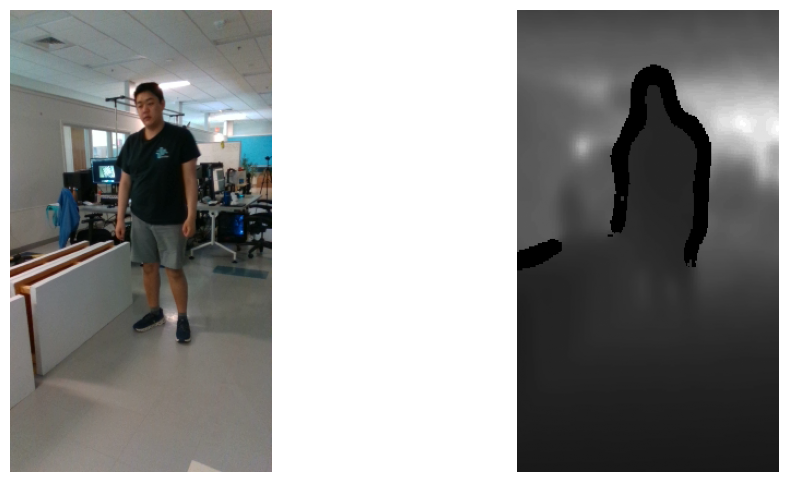

In [43]:
# load image
frame_idx = 263
color_image = images[frame_idx]
depth_image = depths[frame_idx]
# convert depth image to meters
depth_image = depth_image.astype(np.float32) / 1000.0  # Assuming depth image is in millimeters
# visualize color and depth images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(color_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(depth_image, cmap='gray')
plt.axis('off')
plt.show()


0: 640x384 1 person, 2 chairs, 3 tvs, 7.4ms
Speed: 0.9ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)
YOLO inference took 0.25 seconds
1 found: [[95.00971221923828, 65.92281341552734, 174.3566131591797, 306.2892761230469]]


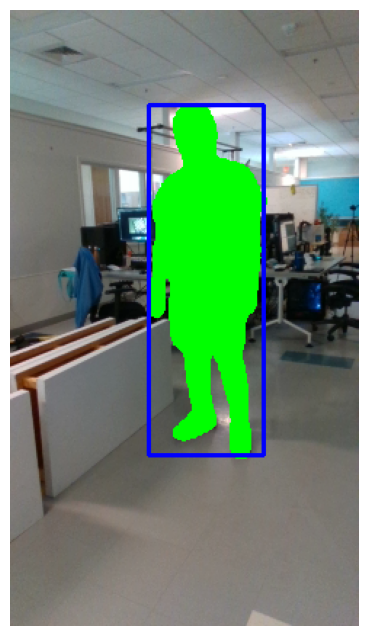

In [44]:
yolo_start = time.time()
results = yolo_model(color_image)
print(f"YOLO inference took {time.time() - yolo_start:.2f} seconds")

humans = []
# Iterate through NMS results to draw bounding boxes and labels
for mask, box in zip(results[0].masks.xy, results[0].boxes):
    if CLASSES[int(box.cls[0].item())].lower() not in ['person']:
        continue
    humans.append((mask, box.xyxy.cpu().numpy().flatten().tolist()))

detection_image = color_image.copy()
if len(humans) > 0:
    print(f"{len(humans)} found: {[box for (mask, box) in humans]}")

    for (mask, box) in humans:
        cv2.fillPoly(detection_image, np.int32([mask]), (0, 255, 0))
        detection_image = add_box(detection_image, box)
# Show color img
plt.figure(figsize=(8, 8))
plt.imshow(detection_image)
plt.axis('off')
plt.show()

In [61]:
import open3d as o3d
def depth2PointCloud(depth, rgb, depth_scale, clip_distance_max, mask, intrinsics):
    [fx, fy, cx, cy] = intrinsics
    depth = depth * depth_scale # 1000 mm => 0.001 meters
    rows,cols  = depth.shape

    c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
    r = r.astype(float)
    c = c.astype(float)
    z = depth 
    x =  z * (c - cx) / fx
    y =  z * (r - cy) / fy

    depth = depth[np.where(mask>0)]

    valid = (depth > 0) & (depth < clip_distance_max) #& (np.median(depth)-1.5*stdev < depth) & (depth < np.median(depth)+1.5*stdev) #remove from the depth image all values above a given value (meters).
    valid = np.ravel(valid)
    
    z = np.ravel(z[np.where(mask>0)])[valid]
    x = np.ravel(x[np.where(mask>0)])[valid]
    y = np.ravel(y[np.where(mask>0)])[valid]
    
    r = np.ravel(rgb[:,:,2][np.where(mask>0)])[valid]
    g = np.ravel(rgb[:,:,1][np.where(mask>0)])[valid]
    b = np.ravel(rgb[:,:,0][np.where(mask>0)])[valid]
    
    pointsxyzrgb = np.dstack((x, y, z, r, g, b))
    pointsxyzrgb = pointsxyzrgb.reshape(-1,6)
    # print(f"Point cloud size: {pointsxyzrgb.shape}")

    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(pointsxyzrgb[:,:3])
    if(pointsxyzrgb.shape[1]>3):
        rgb_t = pointsxyzrgb[:,3:]
        pc.colors = o3d.utility.Vector3dVector(rgb_t.astype(float) / 255.0)
    pc = pc.voxel_down_sample(voxel_size=0.00001)

    return pc

In [62]:
# convert mask from points to 0/1 over whole image
pcd_mask = np.zeros_like(depth_image, dtype=np.uint8)
for mask, box in humans:
    cv2.fillPoly(pcd_mask, np.int32([mask]), 1)

pointcloud = depth2PointCloud(depth_image, cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR), 1,
                              10.0, pcd_mask,
                              [K[0, 0], K[1, 1], K[0, 2], K[1, 2]])
# Visualize point cloud
o3d.visualization.draw_geometries([pointcloud],
                                      width=800, height=600)

In [ ]:
# box_mask = np.zeros_like(depth_image, dtype=np.uint8)
# for mask, box in humans:
#     # Create a mask for the bounding box
#     x1, y1, x2, y2 = map(int, box)
#     cv2.rectangle(box_mask, (x1, y1), (x2, y2), 1, thickness=cv2.FILLED)

# pointcloud2 = depth2PointCloud(depth_image, cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR), 1,
#                               10.0, box_mask,
#                               [K[0, 0], K[1, 1], K[0, 2], K[1, 2]])
# # Visualize point cloud
# o3d.visualization.draw_geometries([pointcloud2],
#                                       width=800, height=600)

# # Clustering the point cloud
# labels = np.array(pointcloud2.cluster_dbscan(eps=0.02, min_points=40))
# print(f"Number of clusters found: {len(np.unique(labels)) - 1}")  # -1 for noise
# largest_cluster_id = np.argmax(np.bincount(labels[labels >= 0]))
# print(f"Largest cluster ID: {largest_cluster_id}")
# pointcloud3 = pointcloud2.select_by_index(np.where(labels == largest_cluster_id)[0])
# o3d.visualization.draw_geometries([pointcloud3],
#                                       width=800, height=600)

Number of clusters found: 0
Largest cluster ID: 0


In [ ]:
# get center of pointcloud
center = pointcloud.get_center()
print(f"Center of point cloud: {center}")


Center of point cloud: [-0.00063258  0.00059476   0.0024172]
Average of point cloud points: [-0.00063258  0.00059476   0.0024172]
